<>:23: SyntaxWarning:

invalid escape sequence '\s'

<>:23: SyntaxWarning:

invalid escape sequence '\s'

/var/folders/ps/l87rj9215hd5rjf5zqwjz04h0000gq/T/ipykernel_73644/1590712477.py:23: SyntaxWarning:

invalid escape sequence '\s'



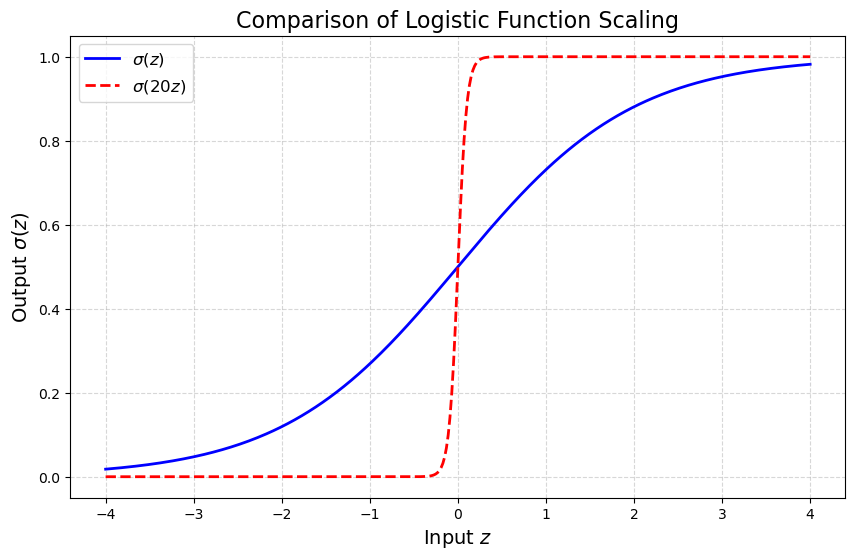

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Define the sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Define a range of z values
z = np.linspace(-4, 4, 400)

# Compute sigmoid(z) and sigmoid(20z)
sig_z = sigmoid(z)
sig_20z = sigmoid(20 * z)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(z, sig_z, label=r'$\sigma(z)$', color='blue', linewidth=2)
plt.plot(z, sig_20z, label=r'$\sigma(20z)$', color='red', linestyle='--', linewidth=2)

# Add titles and labels
plt.title('Comparison of Logistic Function Scaling', fontsize=16)
plt.xlabel('Input $z$', fontsize=14)
plt.ylabel('Output $\sigma(z)$', fontsize=14)

# Add a legend
plt.legend(fontsize=12)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.5)

# Show the plot
plt.show()

In [ ]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import ipywidgets as widgets
from IPython.display import display

# ========== Base class for parametric 1D functions ==========

class ParametricFunction1D:
    """
    Generic 1D parametric function f(x; params).
    Subclasses define:
      - internal name (for code)
      - display_name (for UI)
      - latex (for labels)
      - param_specs: list of dict(name,label,min,max,step,default)
      - _evaluate(x, params)
    """
    def __init__(self, name, display_name, latex, param_specs):
        self.name = name
        self.display_name = display_name
        self.latex = latex
        self.param_specs = param_specs
        self.params = {spec["name"]: spec["default"] for spec in param_specs}

    def set_param(self, name, value):
        if name in self.params:
            self.params[name] = value

    def get_param_specs(self):
        return self.param_specs

    def get_display_name(self):
        return self.display_name

    def get_latex(self):
        return self.latex

    def __call__(self, x):
        return self._evaluate(np.asarray(x), self.params)

    def _evaluate(self, x, params):
        raise NotImplementedError


# ========== f(x) functors ==========

class GaussianF(ParametricFunction1D):
    """
    Normal pdf N(mu, sigma) plus vertical offset b.
    """
    def __init__(self):
        specs = [
            dict(name="mu",    label="μ",          min=-2.0, max=8.0, step=0.1, default=1.2),
            dict(name="sigma", label="σ",          min=0.2,  max=3.0, step=0.1, default=1.0),
            dict(name="b",     label="b (offset)", min=-0.5, max=0.5, step=0.05, default=0.0),
        ]
        super().__init__(
            name="gaussian",
            display_name="Gaussian",
            latex=r"f(x)=\mathcal{N}(x;\mu,\sigma^2)+b",
            param_specs=specs
        )

    def _evaluate(self, x, p):
        mu, sigma, b = p["mu"], p["sigma"], p["b"]
        coef = 1.0 / (sigma * np.sqrt(2.0 * np.pi))
        return coef * np.exp(-0.5 * ((x - mu) / sigma) ** 2) + b


class GaussianMixtureF(ParametricFunction1D):
    """
    0.5 * N(mu1, sigma1) + 0.5 * N(mu2, sigma2) + offset b.
    """
    def __init__(self):
        specs = [
            dict(name="mu1",    label="μ₁",        min=-2.0, max=8.0, step=0.1, default=1.2),
            dict(name="sigma1", label="σ₁",        min=0.2,  max=3.0, step=0.1, default=1.0),
            dict(name="mu2",    label="μ₂",        min=-2.0, max=8.0, step=0.1, default=3.5),
            dict(name="sigma2", label="σ₂",        min=0.2,  max=3.0, step=0.1, default=1.0),
            dict(name="b",      label="b (offset)",min=-0.5, max=0.5, step=0.05, default=0.0),
        ]
        super().__init__(
            name="gaussian_mixture",
            display_name="Gaussian mixture",
            latex=r"f(x)=\tfrac12\mathcal{N}(x;\mu_1,\sigma_1^2)+\tfrac12\mathcal{N}(x;\mu_2,\sigma_2^2)+b",
            param_specs=specs
        )

    def _evaluate(self, x, p):
        mu1, s1 = p["mu1"], p["sigma1"]
        mu2, s2 = p["mu2"], p["sigma2"]
        b       = p["b"]
        coef1 = 1.0 / (s1 * np.sqrt(2.0 * np.pi))
        coef2 = 1.0 / (s2 * np.sqrt(2.0 * np.pi))
        g1 = coef1 * np.exp(-0.5 * ((x - mu1) / s1) ** 2)
        g2 = coef2 * np.exp(-0.5 * ((x - mu2) / s2) ** 2)
        return 0.5 * g1 + 0.5 * g2 + b


class MultiPeakF(ParametricFunction1D):
    """
    Multi-peak function: Gaussian envelope * (0.6 + 0.4 cos(3x)) + offset b.
    """
    def __init__(self):
        specs = [
            dict(name="mu",    label="μ",          min=-2.0, max=8.0, step=0.1, default=2.0),
            dict(name="sigma", label="σ",          min=0.2,  max=3.0, step=0.1, default=1.0),
            dict(name="b",     label="b (offset)", min=-0.5, max=0.5, step=0.05, default=0.0),
        ]
        super().__init__(
            name="multi_peak",
            display_name="multi-peak",
            latex=r"f(x)=\exp\!\big(-\tfrac12\tfrac{(x-\mu)^2}{\sigma^2}\big)\,\big(0.6+0.4\cos(3x)\big)+b",
            param_specs=specs
        )

    def _evaluate(self, x, p):
        mu, sigma, b = p["mu"], p["sigma"], p["b"]
        envelope = np.exp(-0.5 * ((x - mu) / sigma) ** 2)
        return envelope * (0.6 + 0.4 * np.cos(3.0 * x)) + b


class ParabolaF(ParametricFunction1D):
    """
    Parabola: f_{μ,a,b}(x) = a * (x - μ)^2 + b.
    a can be negative → concave down with finite maximum.
    """
    def __init__(self):
        specs = [
            dict(name="mu", label="μ₀",
                 min=-2.0, max=8.0, step=0.1, default=1.0),
            dict(name="a",  label="a (scale)",
                 min=-3.0, max=3.0, step=0.1, default=1.0),
            dict(name="b",  label="b (offset)",
                 min=-5.0, max=5.0, step=0.5, default=0.0),
        ]
        super().__init__(
            name="parabola",
            display_name="parabola",
            latex=r"f(x)=a\,(x-\mu_0)^2 + b",
            param_specs=specs
        )

    def _evaluate(self, x, p):
        mu, a, b = p["mu"], p["a"], p["b"]
        return a * (x - mu) ** 2 + b


F_FUNCTORS = [
    GaussianF(),
    GaussianMixtureF(),
    MultiPeakF(),
    ParabolaF(),
]


# ========== g(y) functors ==========

class IdentityG(ParametricFunction1D):
    def __init__(self):
        specs = []
        super().__init__(
            name="identity",
            display_name="y",
            latex=r"g(y)=y",
            param_specs=specs
        )

    def _evaluate(self, y, p):
        return y


class PowerG(ParametricFunction1D):
    def __init__(self):
        specs = [
            dict(name="p", label="p", min=0.1, max=5.0, step=0.1, default=1.0),
        ]
        super().__init__(
            name="power",
            display_name="y^p",
            latex=r"g(y)=y^p",
            param_specs=specs
        )

    def _evaluate(self, y, p):
        y = np.asarray(y)
        pp = max(p["p"], 1e-9)
        return np.sign(y) * (np.abs(y) ** pp)


class Log1pG(ParametricFunction1D):
    def __init__(self):
        specs = [
            dict(name="a", label="a", min=0.1, max=5.0, step=0.1, default=1.0),
        ]
        super().__init__(
            name="log1p",
            display_name="log(1 + a y)",
            latex=r"g(y)=\log(1+ay)",
            param_specs=specs
        )

    def _evaluate(self, y, p):
        a = max(p["a"], 1e-9)
        return np.log1p(np.clip(a * y, -0.9999, None))


class ExpG(ParametricFunction1D):
    def __init__(self):
        specs = [
            dict(name="a", label="a", min=-2.0, max=2.0, step=0.1, default=0.5),
        ]
        super().__init__(
            name="exp",
            display_name="exp(a y)",
            latex=r"g(y)=e^{ay}",
            param_specs=specs
        )

    def _evaluate(self, y, p):
        return np.exp(p["a"] * y)


class AffineG(ParametricFunction1D):
    def __init__(self):
        specs = [
            dict(name="a", label="a", min=0.1, max=5.0, step=0.1, default=1.0),
        ]
        super().__init__(
            name="affine",
            display_name="a y",
            latex=r"g(y)=ay",
            param_specs=specs
        )

    def _evaluate(self, y, p):
        return max(p["a"], 1e-9) * y


class OffsetG(ParametricFunction1D):
    def __init__(self):
        specs = [
            dict(name="c", label="c", min=-2.0, max=2.0, step=0.1, default=0.0),
        ]
        super().__init__(
            name="offset",
            display_name="y + c",
            latex=r"g(y)=y+c",
            param_specs=specs
        )

    def _evaluate(self, y, p):
        return y + p["c"]


class NegativeLinearG(ParametricFunction1D):
    def __init__(self):
        specs = [
            dict(name="a", label="a", min=0.1, max=5.0, step=0.1, default=1.0),
        ]
        super().__init__(
            name="neg_linear",
            display_name="-a y",
            latex=r"g(y)=-ay",
            param_specs=specs
        )

    def _evaluate(self, y, p):
        return -max(p["a"], 1e-9) * y


class SigmoidG(ParametricFunction1D):
    def __init__(self):
        specs = [
            dict(name="a", label="a",           min=0.1, max=10.0, step=0.1, default=3.0),
            dict(name="c", label="c (center)",  min=-2.0, max=2.0,  step=0.1, default=0.0),
        ]
        super().__init__(
            name="sigmoid",
            display_name="sigmoid(a (y - c))",
            latex=r"g(y)=\frac{1}{1+e^{-a(y-c)}}",
            param_specs=specs
        )

    def _evaluate(self, y, p):
        a = max(p["a"], 1e-9)
        c = p["c"]
        return 1.0 / (1.0 + np.exp(-a * (y - c)))


G_FUNCTORS = [
    IdentityG(),
    PowerG(),
    Log1pG(),
    ExpG(),
    AffineG(),
    OffsetG(),
    NegativeLinearG(),
    SigmoidG(),
]


# ========== Figure builder using functors only ==========

def build_figure(f_functor, g_functor, Xmax_right=6.0, horizontal_spacing=0.03):
    # Right: f(x) and h(x)=g(f(x)) over [0, Xmax_right]
    x = np.linspace(0, Xmax_right, 900)
    y_fx = f_functor(x)
    y_hx = g_functor(y_fx)

    # Argmax of f and h
    idx_f_star = int(np.argmax(y_fx))
    x_f_star = float(x[idx_f_star])
    y_f_star = float(y_fx[idx_f_star])

    idx_h_star = int(np.argmax(y_hx))
    x_h_star = float(x[idx_h_star])
    y_h_star = float(y_hx[idx_h_star])

    # Shared y-range
    y_min = min(0.0, np.min(y_fx), np.min(y_hx))
    y_max = max(np.max(y_fx), np.max(y_hx), 1.0)
    y_bottom = 1.2 * y_min if y_min < 0 else 0.0
    y_top = 1.2 * y_max

    # Left: rotated g(y) with y in [max(0,y_bottom), y_top]
    y_grid_low = max(0.0, y_bottom)
    y_grid = np.linspace(y_grid_low, y_top, 700)
    z_vals = g_functor(y_grid)

    zmin, zmax = float(np.min(z_vals)), float(np.max(z_vals))
    span = max(zmax - zmin, 1e-12)
    g_scaled = (z_vals - zmin) / span * Xmax_right
    x_left = -g_scaled

    # Point on left corresponding to y_f_star: z = g(f(x_f*))
    z_star = g_functor(y_f_star)
    z_star_scaled = (z_star - zmin) / max(span, 1e-12) * Xmax_right
    x_star_left = -float(z_star_scaled)

    # Subplots
    fig = make_subplots(
        rows=1, cols=2,
        horizontal_spacing=horizontal_spacing,
        column_widths=[0.48, 0.52],
        subplot_titles=(
            "Rotated z = g(y)  (x = -g(y))",
            "y = f(x) and h(x) = g(f(x))"
        )
    )

    # Left panel
    fig.add_trace(
        go.Scatter(x=x_left, y=y_grid, mode="lines", name="x = -g(y)"),
        row=1, col=1
    )
    fig.add_trace(
        go.Scatter(x=[x_star_left], y=[y_f_star], mode="markers",
                   name="(-g(f(x_f*)), f(x_f*))", marker=dict(size=8)),
        row=1, col=1
    )

    # Right panel
    fig.add_trace(
        go.Scatter(x=x, y=y_fx, mode="lines", name="f(x)"),
        row=1, col=2
    )
    fig.add_trace(
        go.Scatter(x=x, y=y_hx, mode="lines", name="h(x) = g(f(x))"),
        row=1, col=2
    )

    # Dots at argmax f and h
    fig.add_trace(
        go.Scatter(x=[x_f_star], y=[y_f_star], mode="markers",
                   name="(x_f*, f(x_f*))", marker=dict(size=8)),
        row=1, col=2
    )
    fig.add_trace(
        go.Scatter(x=[x_h_star], y=[y_h_star], mode="markers",
                   name="(x_h*, h(x_h*))", marker=dict(size=8)),
        row=1, col=2
    )

    # Vertical at argmax f
    fig.add_vline(x=x_f_star, line_dash="dash", line_width=2, line_color="gray",
                  row=1, col=2)

    # Dotted vertical from (x_h*,0) to (x_h*,h(x_h*))
    fig.add_trace(
        go.Scatter(
            x=[x_h_star, x_h_star],
            y=[0.0, y_h_star],
            mode="lines",
            line=dict(dash="dot"),
            name="max h(x) vertical"
        ),
        row=1, col=2
    )

    # Horizontal at f(x_f*) across both
    fig.add_hline(y=y_f_star, line_dash="dot", line_width=1.5, line_color="teal",
                  row=1, col=1)
    fig.add_hline(y=y_f_star, line_dash="dot", line_width=1.5, line_color="teal",
                  row=1, col=2)

    # Axes & layout
    z_ticks = np.linspace(zmin, zmax, 4)
    x_tickvals = - (z_ticks - zmin) / max(span, 1e-12) * Xmax_right
    x_ticktext = [f"{zt:.2f}" for zt in z_ticks]

    fig.update_xaxes(
        title_text="z (increasing to the left)",
        range=[-Xmax_right, 0],
        showgrid=True,
        zeroline=False,
        tickvals=x_tickvals,
        ticktext=x_ticktext,
        row=1, col=1
    )
    fig.update_yaxes(
        title_text="y",
        range=[y_bottom, y_top],
        showgrid=True,
        row=1, col=1
    )

    fig.update_xaxes(
        title_text="x",
        range=[0, Xmax_right],
        showgrid=True,
        zeroline=False,
        row=1, col=2
    )
    fig.update_yaxes(
        title_text="y",
        range=[y_bottom, y_top],
        showgrid=True,
        row=1, col=2
    )

    # LaTeX title using MathJax
    fig.update_layout(
        autosize=True,
        title={
            "text": f"$ {f_functor.get_latex()}$,   $h(x)=g(f(x))$ with $ {g_functor.get_latex()}$",
            "x": 0.5,
            "xanchor": "center"
        },
        legend=dict(
            orientation="v",
            yanchor="middle", y=0.5,
            xanchor="left",   x=1.02
        ),
        margin=dict(l=30, r=80, t=70, b=30),
        template="plotly_white"
    )
    return fig


# ========== UI wiring ==========

# Dropdowns select functor *indices* into the lists
f_dropdown = widgets.Dropdown(
    options=[(f.get_display_name(), i) for i, f in enumerate(F_FUNCTORS)],
    value=0,
    description="f(x):"
)

g_dropdown = widgets.Dropdown(
    options=[(g.get_display_name(), i) for i, g in enumerate(G_FUNCTORS)],
    value=1,  # default to y^p
    description="g(y):"
)

f_params_box = widgets.VBox()
g_params_box = widgets.VBox()
fig_out = widgets.Output(layout=widgets.Layout(width="100%"))

current_f = F_FUNCTORS[f_dropdown.value]
current_g = G_FUNCTORS[g_dropdown.value]

slider_to_param = {}  # slider -> (functor, param_name)


def build_param_sliders(functor, box):
    """Create sliders for functor.param_specs and attach them to box."""
    global slider_to_param
    children = []
    for spec in functor.get_param_specs():
        slider = widgets.FloatSlider(
            value=spec["default"],
            min=spec["min"],
            max=spec["max"],
            step=spec["step"],
            description=spec["label"],
            continuous_update=False
        )
        slider_to_param[slider] = (functor, spec["name"])

        def on_slider_change(change, s=slider):
            if change["name"] == "value":
                func, pname = slider_to_param[s]
                func.set_param(pname, change["new"])
                update_plot()

        slider.observe(on_slider_change, names="value")
        children.append(slider)

    box.children = children


def update_functors(change=None):
    global current_f, current_g
    current_f = F_FUNCTORS[f_dropdown.value]
    current_g = G_FUNCTORS[g_dropdown.value]
    build_param_sliders(current_f, f_params_box)
    build_param_sliders(current_g, g_params_box)
    update_plot()


def update_plot(*args):
    with fig_out:
        fig_out.clear_output(wait=True)
        fig = build_figure(current_f, current_g)
        fig.show(config={"responsive": True})


# Wire dropdown changes
f_dropdown.observe(update_functors, names="value")
g_dropdown.observe(update_functors, names="value")

# Initial sliders and plot
build_param_sliders(current_f, f_params_box)
build_param_sliders(current_g, g_params_box)

g_box = widgets.VBox([widgets.HTML("<b>g(y) controls</b>"), g_dropdown, g_params_box])
f_box = widgets.VBox([widgets.HTML("<b>f(x) controls</b>"), f_dropdown, f_params_box])

controls_row = widgets.HBox([g_box, f_box])

display(controls_row)
display(fig_out)

update_plot()


Output(layout=Layout(width='100%'))